In [1]:
import torch,gc
from torch import nn
from torchvision import transforms


import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
file_path = Path("mini_food/pizza_steak_sushi/")

train_dir = file_path/"train"
test_dir = file_path/"test"


In [6]:
image_transform = transforms.Compose(
    [
        transforms.Resize(size=(224,224)),
        transforms.ToTensor()
    ]
)

In [8]:
from data_setup import create_dataloaders


train_dataloader,test_dataloader,class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=image_transform,
    batch_size=32
)

In [9]:
class_names

['pizza', 'steak', 'sushi']

(-0.5, 223.5, 223.5, -0.5)

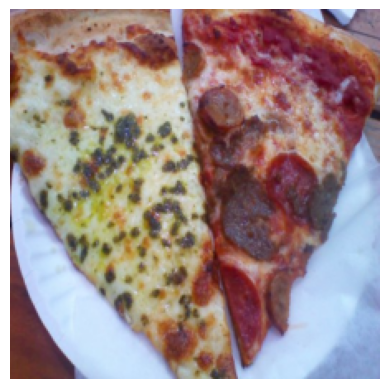

In [12]:
image_batch,label_batch = next(iter(train_dataloader))
test_image,test_label = image_batch[0],label_batch[0]

plt.imshow(test_image.permute(1,2,0))
plt.axis(False)

In [15]:
patch_size = 16
height = 224
width = 224
color_channels = 3

N = int((height*width)//patch_size**2)
N

196

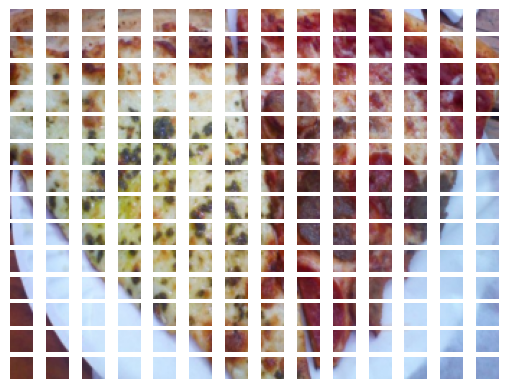

In [24]:
img_size = 224
no_of_patches = img_size // patch_size
k=1
for i in range(no_of_patches):
    for j in range(no_of_patches):
        plt.subplot(no_of_patches,no_of_patches,k)
        plt.imshow(test_image.permute(1,2,0)[i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size,:])
        plt.axis(False)
        k+=1

In [28]:
class Permute(nn.Module):
    def __init__(self,dim):
        super().__init__()
        self.dim = dim
    
    def forward(self,x):
        return x.permute(self.dim)
class PatchEmbedding(nn.Module):
    
    def __init__(self,in_channels,patch_size,embedding_dim):
        super().__init__()
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            padding=0,
            kernel_size=patch_size,
            stride=patch_size
        )
        
        self.flatten = nn.Sequential(nn.Flatten(
            start_dim=2,
            end_dim=3
            ),
                                     Permute((0,2,1)))
        
    def forward(self,x):
        print(f"x Shape Before Patched : {x.shape}")
        x_patched = self.patcher(x)
        print(f"x SHape After Patched: {x_patched.shape}")
        
        x_flattened = self.flatten(x_patched)
        print(f"x Shape After Flattened and Permuted: {x_flattened.shape}")
        
        return x_flattened
        

In [30]:
patcher = PatchEmbedding(in_channels=3,
                         patch_size=patch_size,
                         embedding_dim=768)

print(f"Input Image Size:{test_image.shape}")
patched_image = patcher(test_image.unsqueeze(0))
print(f"Ouput Image Size:{patched_image.shape}")

Input Image Size:torch.Size([3, 224, 224])
x Shape Before Patched : torch.Size([1, 3, 224, 224])
x SHape After Patched: torch.Size([1, 768, 14, 14])
x Shape After Flattened and Permuted: torch.Size([1, 196, 768])
Ouput Image Size:torch.Size([1, 196, 768])


In [31]:
batch_size = patched_image.shape[0]
embedding_dim = patched_image.shape[-1]
batch_size,embedding_dim

(1, 768)

In [32]:
class_token = nn.Parameter(
    torch.ones(batch_size,1,embedding_dim)
)
class_token.shape

torch.Size([1, 1, 768])

In [34]:
patched_image_with_class_token = torch.cat((class_token,patched_image),dim=1)
patched_image_with_class_token.shape

torch.Size([1, 197, 768])

In [50]:
position_embedding = nn.Parameter(torch.ones(
    batch_size,
    1+N,
    embedding_dim
))
position_embedding.shape

torch.Size([1, 197, 768])

In [51]:
patched_and_pos_embed = patched_image_with_class_token + position_embedding
patched_and_pos_embed,patched_and_pos_embed.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [1.0603, 0.7560, 1.0140,  ..., 0.9756, 1.3316, 1.3528],
          [1.0398, 0.7916, 0.9843,  ..., 1.0390, 1.3240, 1.3595],
          ...,
          [1.1487, 0.7535, 1.3783,  ..., 1.0814, 1.6725, 1.6483],
          [1.0674, 0.8464, 1.3450,  ..., 1.0863, 1.5117, 1.5673],
          [1.0861, 0.8633, 1.3251,  ..., 1.0831, 1.5213, 1.5815]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [52]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self,embedding_dim,num_heads,attn_dropout=0):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )
        
    
    def forward(self,x):
        x_lnorm = self.layer_norm(x)
        attn_out = self.multihead_attn(
            query = x_lnorm,
            key = x_lnorm,
            value = x_lnorm,
            need_weights = False
        )
    
        return attn_out
    


In [57]:
mha_block = MultiHeadAttentionBlock(embedding_dim=embedding_dim,
                                    num_heads=12,
                                    attn_dropout=0)

patched_and_pos_embed_attn_out,_ = mha_block(patched_and_pos_embed)
patched_and_pos_embed,patched_and_pos_embed_attn_out,patched_and_pos_embed.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [1.0603, 0.7560, 1.0140,  ..., 0.9756, 1.3316, 1.3528],
          [1.0398, 0.7916, 0.9843,  ..., 1.0390, 1.3240, 1.3595],
          ...,
          [1.1487, 0.7535, 1.3783,  ..., 1.0814, 1.6725, 1.6483],
          [1.0674, 0.8464, 1.3450,  ..., 1.0863, 1.5117, 1.5673],
          [1.0861, 0.8633, 1.3251,  ..., 1.0831, 1.5213, 1.5815]]],
        grad_fn=<AddBackward0>),
 tensor([[[-0.9873,  0.3603,  0.2506,  ...,  0.3106, -0.2788,  0.1709],
          [-0.9716,  0.3586,  0.2584,  ...,  0.3107, -0.2777,  0.1610],
          [-0.9728,  0.3601,  0.2557,  ...,  0.3115, -0.2766,  0.1638],
          ...,
          [-0.9719,  0.3594,  0.2544,  ...,  0.3111, -0.2797,  0.1665],
          [-0.9728,  0.3595,  0.2521,  ...,  0.3105, -0.2791,  0.1680],
          [-0.9725,  0.3594,  0.2525,  ...,  0.3106, -0.2785,  0.1677]]],
        grad_fn=<TransposeBackward0>),
 torch.Size([1, 197, 768]))

In [58]:
class MLPBlock(nn.Module):
    def __init__(self,embedding_dim,mlp_size,dropout=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(
                in_features=embedding_dim,
                out_features=mlp_size
            ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=mlp_size,
                out_features=embedding_dim
            ),
            nn.Dropout(p=dropout)
        )
        
    def forward(self,x):
        x_lnorm = self.layer_norm(x)
        
        x_mlp = self.mlp(x_lnorm)
        
        return x_mlp

In [59]:
patched_and_pos_embed_attn_out

tensor([[[-0.9873,  0.3603,  0.2506,  ...,  0.3106, -0.2788,  0.1709],
         [-0.9716,  0.3586,  0.2584,  ...,  0.3107, -0.2777,  0.1610],
         [-0.9728,  0.3601,  0.2557,  ...,  0.3115, -0.2766,  0.1638],
         ...,
         [-0.9719,  0.3594,  0.2544,  ...,  0.3111, -0.2797,  0.1665],
         [-0.9728,  0.3595,  0.2521,  ...,  0.3105, -0.2791,  0.1680],
         [-0.9725,  0.3594,  0.2525,  ...,  0.3106, -0.2785,  0.1677]]],
       grad_fn=<TransposeBackward0>)

In [60]:
mlp_block = MLPBlock(
    embedding_dim=embedding_dim,
    mlp_size=3072,
    dropout=0.1
)

patched_and_pos_embed_attn_out_and_mlp_out = mlp_block(patched_and_pos_embed_attn_out)
patched_and_pos_embed_attn_out_and_mlp_out,patched_and_pos_embed_attn_out_and_mlp_out.shape

(tensor([[[-0.2566,  0.1926,  0.0000,  ..., -0.0631,  0.0000,  0.0861],
          [-0.2840,  0.0639,  0.3312,  ...,  0.0456,  0.2572,  0.1005],
          [-0.0000,  0.1107,  0.2783,  ..., -0.0534,  0.3170,  0.0458],
          ...,
          [-0.1477,  0.1703,  0.3802,  ...,  0.1080,  0.3471,  0.0189],
          [-0.1207,  0.0968,  0.2064,  ...,  0.1092,  0.3041,  0.2353],
          [-0.1255,  0.2567,  0.3673,  ...,  0.1271,  0.3293,  0.0735]]],
        grad_fn=<MulBackward0>),
 torch.Size([1, 197, 768]))